# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import sys

from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
display(len(cities))

597

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


### Handling limited API requests
- The number of requests from openweather api is limited to 60 requests per minute. To stay inside this limit
1. Divide the cities into sets of 60
2. Request api for every 0.1 second using time.sleep(0.1)
3. Make sure that the requests are limited to 1 set per minute, by waiting the aditional amount at the end of the set

In [3]:
api_req_limit = 60   # number of requests limited per minute
number_of_sets = int(len(cities)/api_req_limit) + 1
city_count = 0   # counter runs through the list cities

# Variables to hold in the dataframe for each city
latitude_lst = []
longitude_lst = []
max_temperature_lst = []
humidity_lst = []
cloud_coverage_lst = []
wind_speed_lst = []
country_lst = []
datetime_lst = []
city_lst = []

for six in range(number_of_sets):
    start_time = time.time()   # in seconds
    for cix in range(api_req_limit):
        try:
            city = cities[city_count]
        except IndexError:  # api_req_limit*number_of_sets may exceed len(cities), giving and IndexError
            print("---------------------------")
            print("Data Retrieval Complete")
            print("---------------------------")
            break
        print("Processing Record %d of Set %d/%d | %s" % (city_count, six+1, number_of_sets, city),
              end="                \r", flush=True)   # Clear line and flush output
        
        request_url = "https://api.openweathermap.org/data/2.5/weather?q=%s&appid=%s" % (city, weather_api_key)
        
        response = requests.get(request_url)
        response_json = response.json()
        
        if response_json["cod"] == "404":  # Print Error Message
            print(response_json["message"] + f" ({city})                ")
        else:
            # Append information from json to a list
            city_lst.append(city)
            latitude_lst.append(response_json["coord"]["lat"])
            longitude_lst.append(response_json["coord"]["lon"])
            max_temperature_lst.append(response_json["main"]["temp_max"])
            humidity_lst.append(response_json["main"]["humidity"])
            cloud_coverage_lst.append(response_json["clouds"]["all"])
            wind_speed_lst.append(response_json["wind"]["speed"])
            country_lst.append(response_json["sys"]["country"])
            datetime_lst.append(response_json["dt"])
                    
        city_count += 1
        time.sleep(0.5)
    
    set_time = time.time()
    # Wait for additional amount until 1 min is reached if there are more sets to acquire
    if (set_time - start_time) < 60 and (six < number_of_sets-1):
        print("waiting additional %d seconds before moving into Set %d/%d" % (60 - (set_time - start_time), six+2, number_of_sets), 
                end="               \r",   # Clear line and return to beginning
                flush=True)    # Flush output
        time.sleep(np.ceil(60 - (set_time - start_time)))
        

city not found (samusu)                u                        
city not found (karkaralinsk)                k                
city not found (ngukurr)                rr                             
city not found (mys shmidta)                ta                
city not found (attawapiskat)                at                
city not found (tumannyy)                yy                 
city not found (tungkang)                ng                    
city not found (targu-lapus)                us                 
city not found (vaitupu)                pu                             
city not found (satitoa)                oa                     
city not found (anar darreh)                eh                
city not found (achisay)                ay                 
city not found (tabiauea)                uea                            
city not found (nizhneyansk)                nsk                
city not found (macaboboni)                oni                               
city not f

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
city_data_dict = {"City": city_lst,
                  "Cloudiness": cloud_coverage_lst,
                  "Country": country_lst,
                  "Date": datetime_lst,
                  "Humidity": humidity_lst,
                  "Lat": latitude_lst,
                  "Lng": longitude_lst,
                  "Max Temp": max_temperature_lst,
                  "Wind Speed": wind_speed_lst}

city_data_df = pd.DataFrame(city_data_dict)

# Save to csv with no index
csv_path = "C:/Users/Tolga/Dropbox/Data Bootcamp/Homeworks/python-api-challenge/output_data/city_data.csv"
city_data_df.to_csv(csv_path, index_label="City_ID")

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [5]:
mask_of_nonphys_humidity = city_data_df["Humidity"] > 100

if (mask_of_nonphys_humidity.sum() > 0):
    print("Humidity exceeding 100 for rows:")
    city_data_df[mask_of_nonphys_humidity]

In [6]:
#  Get the indices of cities that have humidity over 100%.
index_of_nonphys_humidity = city_data_df[mask_of_nonphys_humidity].index

In [7]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data_df = city_data_df.drop(index = index_of_nonphys_humidity , inplace= False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

<AxesSubplot:xlabel='Lat', ylabel='Max Temp'>

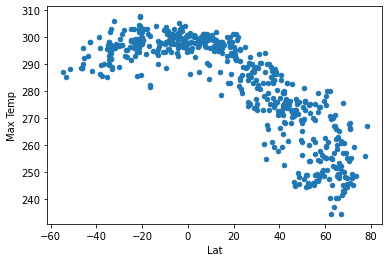

In [8]:
clean_city_data_df.plot(kind="scatter", x="Lat", y="Max Temp")

## Latitude vs. Humidity Plot

<AxesSubplot:xlabel='Lat', ylabel='Humidity'>

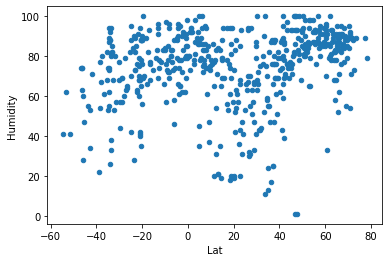

In [10]:
clean_city_data_df.plot(kind="scatter", x="Lat", y="Humidity")

## Latitude vs. Cloudiness Plot

<AxesSubplot:xlabel='Lat', ylabel='Cloudiness'>

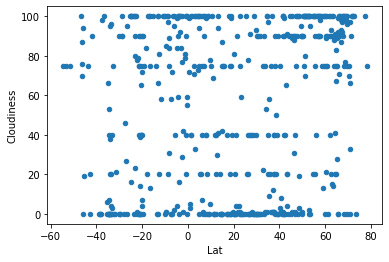

In [11]:
clean_city_data_df.plot(kind="scatter", x="Lat", y="Cloudiness")

## Latitude vs. Wind Speed Plot

<AxesSubplot:xlabel='Lat', ylabel='Wind Speed'>

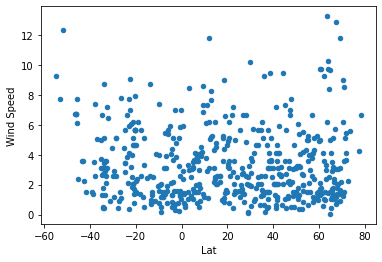

In [12]:
clean_city_data_df.plot(kind="scatter", x="Lat", y="Wind Speed")

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression